<a href="https://colab.research.google.com/github/Jamee95/ubran_sound_classification/blob/code/urban_audio_inspect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **Step 6: Inspect a Sample Audio File**
We’ll load one random audio file from the dataset to confirm:
- File accessibility  
- Audio duration  
- Sampling rate


In [ ]:
import librosa

sample_row = esc.sample(1).iloc[0]
fold = sample_row['fold']
file_name = sample_row['slice_file_name']
sample_path = f"/content/UrbanSound8K/audio/fold{fold}/{file_name}"

print("Sample file:", sample_path)
y, sr = librosa.load(sample_path, sr=None)
print(f"Loaded: {len(y)} samples | Sample rate: {sr} Hz | Duration: {len(y)/sr:.2f}s")


Sample file: /content/UrbanSound8K/audio/fold4/14110-4-0-2.wav
Loaded: 176400 samples | Sample rate: 44100 Hz | Duration: 4.00s


#  **Step 7: Extract MFCC Features**
We’ll convert each audio clip into **MFCC features** (Mel-Frequency Cepstral Coefficients) —  
a compact numerical representation that captures sound characteristics.

Each file will be converted into a **40-dimensional vector**.


In [ ]:
import numpy as np
from tqdm import tqdm

audio_root = "/content/UrbanSound8K/audio"
features, labels = [], []

for i in tqdm(range(len(esc))):
    row = esc.iloc[i]
    fold = row['fold']
    file_name = row['slice_file_name']
    label = row[class_col]
    file_path = os.path.join(audio_root, f"fold{fold}", file_name)

    if not os.path.exists(file_path):
        continue

    try:
        y, sr = librosa.load(file_path, sr=None, res_type='kaiser_fast')
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        mfcc_mean = np.mean(mfcc.T, axis=0)
        features.append(mfcc_mean)
        labels.append(label)
    except Exception as e:
        print(f"Error processing {file_name}: {e}")


 33%|███▎      | 2849/8732 [01:51<02:45, 35.56it/s]/usr/local/lib/python3.12/dist-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
100%|██████████| 8732/8732 [05:47<00:00, 25.12it/s]


#  **Step 8: Create a DataFrame of Features**
Now we’ll organize our extracted MFCC features and labels into a Pandas DataFrame.  
We’ll also confirm the number of successfully processed samples.


In [ ]:
df_us8k = pd.DataFrame(features)
df_us8k["label"] = labels

print("Extracted samples:", len(df_us8k))
display(df_us8k.head())


Extracted samples: 8732


,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,label
0,-275.918427,119.492790,-98.211777,-66.515129,-42.606045,0.505064,-28.330936,-5.746867,9.992785,4.795413,...,-3.562049,1.710329,1.032513,-4.748237,-4.013623,0.116840,6.310030,1.492272,1.462320,dog_bark
1,-500.908386,185.106415,-86.532822,49.858849,9.230822,22.548952,-3.567174,12.220052,7.720082,-6.460391,...,-1.856354,0.372866,-3.269187,-1.969773,-1.598099,0.562077,0.463689,-0.359663,0.909601,children_playing
2,-531.195312,186.939941,-70.349159,40.429245,9.121048,18.398588,6.283282,15.504061,9.613501,-7.113610,...,-0.291962,0.287639,-3.358315,1.434628,-0.975246,2.386079,-0.347919,-3.844178,-0.731598,children_playing
3,-476.784424,160.333282,-62.952843,50.751171,-0.174330,32.791599,-17.469801,24.755478,-3.847783,-1.761176,...,-3.374203,-1.012279,-1.025993,-3.666372,-0.071535,-5.693183,1.876606,-1.428173,3.510686,children_playing
4,-521.244690,185.392654,-81.950478,46.473549,11.872087,23.491444,4.261836,13.637699,6.093238,-2.813453,...,-0.331206,2.441440,0.449653,1.609697,-2.679410,-0.054824,-2.050368,-1.784188,2.869685,children_playing


#  **Step 9: Display Class Counts in Extracted Dataset**
This confirms that all 10 sound categories were processed correctly  
and that class balance matches the original metadata.


In [ ]:
table = df_us8k["label"].value_counts().reset_index()
table.columns = ["Class", "Count"]
display(table)


,Class,Count
0,dog_bark,1000
1,children_playing,1000
2,air_conditioner,1000
3,street_music,1000
4,jackhammer,1000
5,engine_idling,1000
6,drilling,1000
7,siren,929
8,car_horn,429
9,gun_shot,374


/tmp/ipython-input-1451533291.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Class', y='Count', data=class_counts, palette='viridis')


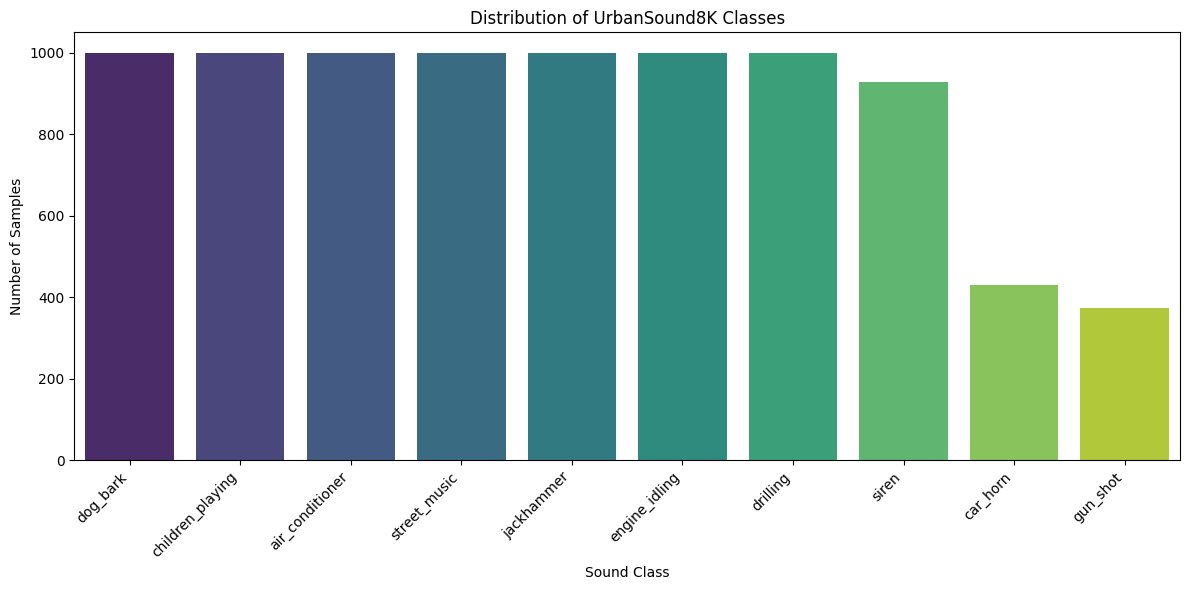

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x='Class', y='Count', data=class_counts, palette='viridis')
plt.xlabel('Sound Class')
plt.ylabel('Number of Samples')
plt.title('Distribution of UrbanSound8K Classes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# ***MODEL TRAINING AND EVALUATION***

#  **Step 10: Encode Labels and Split Dataset**
Before training, we must:
1. Convert class labels into numeric values using **LabelEncoder**  
2. Split the data into **training (80%)** and **testing (20%)** sets  
This ensures fair model evaluation on unseen samples.


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Separate features and labels
X = df_us8k.drop(columns=['label'])
y = df_us8k['label']

# Encode string labels into numeric
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print("Train samples:", len(X_train))
print("Test samples:", len(X_test))
print("Number of classes:", len(le.classes_))


Train samples: 6985
Test samples: 1747
Number of classes: 10
